<a href="https://colab.research.google.com/github/AyushiGupta9723/Analysis-using-sql/blob/master/Trade.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📊 Data Science Project: Trader Performance vs Market Sentiment
**Objective:**  
Explore how trader performance relates to market sentiment (Fear & Greed Index), uncover hidden patterns, and deliver insights to guide smarter trading strategies.

---



In [ ]:

# --- Step 0. Setup ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dateutil import parser

# Make plots look nice
sns.set(style="whitegrid", palette="muted")
plt.rcParams["figure.figsize"] = (10,4)


##1. 📥 Import Libraries & Load Data

In [ ]:
# --- Step 1. Load CSVs ---

# Load into pandas
hist = pd.read_csv("/content/historical_data.csv")
fg = pd.read_csv("/content/fear_greed_index.csv")

print("Historical shape:", hist.shape)
print("Fear & Greed shape:", fg.shape)


Historical shape: (211224, 16)
Fear & Greed shape: (2644, 4)


##2. 🧹 Data Preparation
- Convert timestamps to Indian Standard Time (Kolkata).  
- Extract trading date.  
- Build **daily features**: trades, net PnL, win rate, volatility.  
- Merge with Fear & Greed (FG) index.  



In [ ]:
# --- Step 2a. Parse timestamps in historical_data ---
ts_col = [c for c in hist.columns if "timestamp" in c.lower()][0]
print("Timestamp column:", ts_col)

# Try fast parsing
parsed = pd.to_datetime(hist[ts_col], errors="coerce", infer_datetime_format=True)

# For rows that failed, try dateutil parser (slower but flexible)
mask_un = parsed.isna()
for i, raw in enumerate(hist.loc[mask_un, ts_col].astype(str).unique()):
    try:
        parsed_val = parser.parse(raw, fuzzy=True)
        parsed.loc[hist[ts_col] == raw] = parsed_val
    except:
        continue

hist["_parsed_timestamp"] = pd.to_datetime(parsed, errors="coerce")
hist["_parsed_timestamp"] = hist["_parsed_timestamp"].dt.tz_localize("Asia/Kolkata", ambiguous="NaT", nonexistent="NaT")

print("Parsed timestamps:", hist["_parsed_timestamp"].notna().sum(), "/", len(hist))


Timestamp column: Timestamp IST
Parsed timestamps: 211224 / 211224


In [ ]:
# --- Step 2b. Parse timestamps in fear_greed_index ---
fg["timestamp"] = pd.to_datetime(fg["timestamp"], unit="s", utc=True)
fg["_datetime_kolkata"] = fg["timestamp"].dt.tz_convert("Asia/Kolkata")
fg["date_kolkata"] = fg["_datetime_kolkata"].dt.date

fg["fg_value"] = pd.to_numeric(fg["value"], errors="coerce")
fg = fg[["date_kolkata","fg_value","classification"]]
fg.head()


,date_kolkata,fg_value,classification
0,2018-02-01,30,Fear
1,2018-02-02,15,Extreme Fear
2,2018-02-03,40,Fear
3,2018-02-04,24,Extreme Fear
4,2018-02-05,11,Extreme Fear


In [ ]:
# --- Step 3. Daily aggregation of trades ---
hist_valid = hist[hist["_parsed_timestamp"].notna()].copy()
hist_valid["date_kolkata"] = hist_valid["_parsed_timestamp"].dt.date

# Pick PnL column
pnl_col = "Closed PnL"
hist_valid[pnl_col] = pd.to_numeric(hist_valid[pnl_col], errors="coerce")

# Aggregate
agg = hist_valid.groupby("date_kolkata").agg(
    total_trades = ("_parsed_timestamp","count"),
    net_pnl = (pnl_col,"sum"),
    mean_pnl = (pnl_col,"mean"),
    win_trades = (pnl_col, lambda x: (x>0).sum()),
    loss_trades = (pnl_col, lambda x: (x<0).sum())
)
agg["win_rate"] = agg["win_trades"]/agg["total_trades"]

if "Size USD" in hist_valid.columns:
    hist_valid["Size USD"] = pd.to_numeric(hist_valid["Size USD"], errors="coerce")
    agg["avg_trade_size_usd"] = hist_valid.groupby("date_kolkata")["Size USD"].mean()

agg = agg.reset_index()
agg.head()


,date_kolkata,total_trades,net_pnl,mean_pnl,win_trades,loss_trades,win_rate,avg_trade_size_usd
0,2023-01-05,3,0.000000,0.000000,0,0,0.000000,159.000000
1,2023-05-12,9,0.000000,0.000000,0,0,0.000000,5556.203333
2,2023-12-14,11,-205.434737,-18.675885,4,2,0.363636,10291.213636
3,2023-12-15,2,-24.632034,-12.316017,0,2,0.000000,5304.975000
4,2023-12-16,3,0.000000,0.000000,0,0,0.000000,5116.256667


In [ ]:
# --- Step 4. Merge with Fear & Greed ---
merged = pd.merge(agg, fg, how="left", on="date_kolkata")
print("Merged shape:", merged.shape)
merged.head()


Merged shape: (480, 10)


,date_kolkata,total_trades,net_pnl,mean_pnl,win_trades,loss_trades,win_rate,avg_trade_size_usd,fg_value,classification
0,2023-01-05,3,0.000000,0.000000,0,0,0.000000,159.000000,29.0,Fear
1,2023-05-12,9,0.000000,0.000000,0,0,0.000000,5556.203333,49.0,Neutral
2,2023-12-14,11,-205.434737,-18.675885,4,2,0.363636,10291.213636,72.0,Greed
3,2023-12-15,2,-24.632034,-12.316017,0,2,0.000000,5304.975000,70.0,Greed
4,2023-12-16,3,0.000000,0.000000,0,0,0.000000,5116.256667,67.0,Greed


Correlation FG vs net_pnl: -0.07178173315207437
Correlation FG vs win_rate: 0.10205538791922687


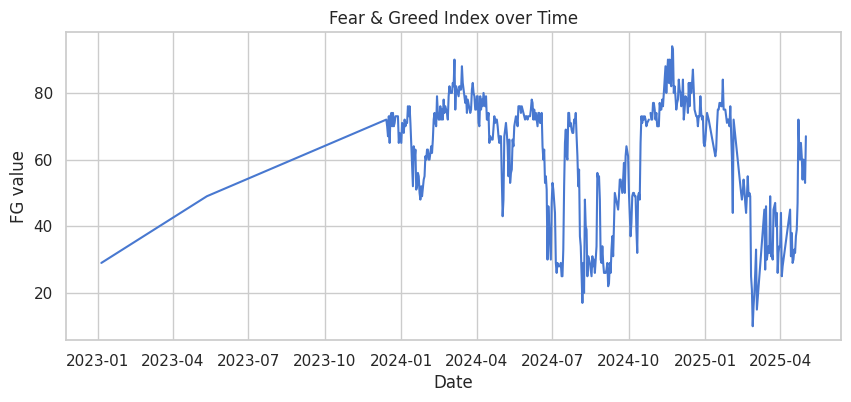

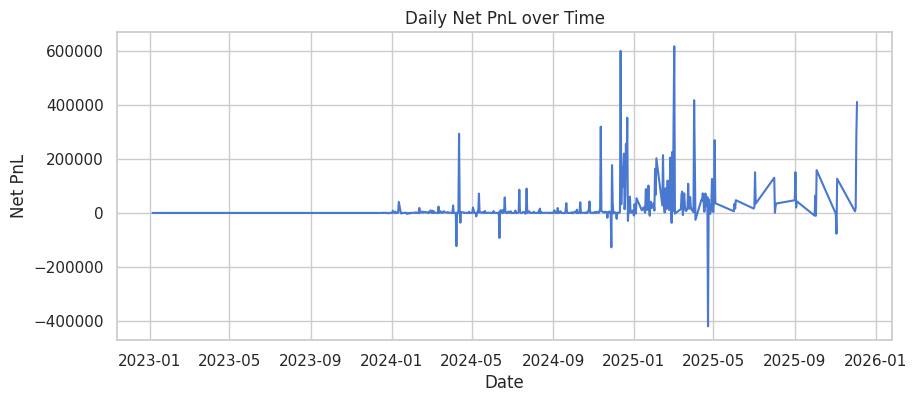

In [ ]:

print("Correlation FG vs net_pnl:", merged["fg_value"].corr(merged["net_pnl"]))
print("Correlation FG vs win_rate:", merged["fg_value"].corr(merged["win_rate"]))

# Plot FG value
plt.plot(pd.to_datetime(merged["date_kolkata"]), merged["fg_value"])
plt.title("Fear & Greed Index over Time")
plt.xlabel("Date")
plt.ylabel("FG value")
plt.show()

# Plot daily net_pnl
plt.plot(pd.to_datetime(merged["date_kolkata"]), merged["net_pnl"])
plt.title("Daily Net PnL over Time")
plt.xlabel("Date")
plt.ylabel("Net PnL")
plt.show()


##3. 🔎 Exploratory Data Analysis

We now analyze relationships between trading performance and market sentiment:
- Correlation heatmap  
- Pairplot of daily features  
- Boxplots/Violinplots by sentiment regimes  
- Trend plots over time  


In [ ]:

import statsmodels.api as sm


In [ ]:
# --- Lag Features for Fear & Greed ---
merged = merged.sort_values("date_kolkata").reset_index(drop=True)

# Convert date to datetime
merged["date_kolkata"] = pd.to_datetime(merged["date_kolkata"])

# Lagged features (1-day, 3-day, 7-day)
for lag in [1,3,7]:
    merged[f"fg_lag{lag}"] = merged["fg_value"].shift(lag)

# Rolling mean & volatility
merged["fg_roll3_mean"] = merged["fg_value"].rolling(3).mean()
merged["fg_roll7_mean"] = merged["fg_value"].rolling(7).mean()
merged["fg_roll7_std"]  = merged["fg_value"].rolling(7).std()

merged.head(10)


,date_kolkata,total_trades,net_pnl,mean_pnl,win_trades,loss_trades,win_rate,avg_trade_size_usd,fg_value,classification,fg_lag1,fg_lag3,fg_lag7,fg_roll3_mean,fg_roll7_mean,fg_roll7_std
0,2023-01-05,3,0.000000,0.000000,0,0,0.000000,159.000000,29.0,Fear,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-05-12,9,0.000000,0.000000,0,0,0.000000,5556.203333,49.0,Neutral,29.0,NaN,NaN,NaN,NaN,NaN
2,2023-12-14,11,-205.434737,-18.675885,4,2,0.363636,10291.213636,72.0,Greed,49.0,NaN,NaN,50.000000,NaN,NaN
3,2023-12-15,2,-24.632034,-12.316017,0,2,0.000000,5304.975000,70.0,Greed,72.0,29.0,NaN,63.666667,NaN,NaN
4,2023-12-16,3,0.000000,0.000000,0,0,0.000000,5116.256667,67.0,Greed,70.0,49.0,NaN,69.666667,NaN,NaN
5,2023-12-17,14,304.982785,21.784485,7,4,0.500000,8305.572857,73.0,Greed,67.0,72.0,NaN,70.000000,NaN,NaN
6,2023-12-18,2,0.000000,0.000000,0,0,0.000000,15582.090000,65.0,Greed,73.0,70.0,NaN,68.333333,60.714286,16.152547
7,2023-12-19,15,1000.538612,66.702574,10,0,0.666667,6106.827333,73.0,Greed,65.0,67.0,29.0,70.333333,67.000000,8.504901
8,2023-12-20,18,162.732282,9.040682,8,0,0.444444,7868.710556,74.0,Greed,73.0,73.0,49.0,70.666667,70.571429,3.408672
9,2023-12-21,49,537.211402,10.963498,26,1,0.530612,2555.795306,70.0,Greed,74.0,65.0,72.0,72.333333,70.285714,3.352327


In [ ]:
# --- Additional trading behavior features ---
# --- Additional trading behavior features (fixed merge types) ---

# Ensure consistent datetime types
merged["date_kolkata"] = pd.to_datetime(merged["date_kolkata"])
hist_valid["date_kolkata"] = pd.to_datetime(hist_valid["date_kolkata"])

# Daily PnL volatility (within a day)
daily_vol = (
    hist_valid.groupby("date_kolkata")[pnl_col]
    .std()
    .rename("daily_pnl_std")
    .reset_index()
)
daily_vol["date_kolkata"] = pd.to_datetime(daily_vol["date_kolkata"])

# Merge safely
merged = pd.merge(merged, daily_vol, on="date_kolkata", how="left")

# Long vs short ratio (if 'Side' column exists)
if "Side" in hist_valid.columns:
    side_ratio = (
        hist_valid.groupby(["date_kolkata","Side"]).size().unstack(fill_value=0)
    )
    side_ratio["long_short_ratio"] = side_ratio.get("LONG",0) / (side_ratio.get("SHORT",1))
    side_ratio = side_ratio.reset_index()
    side_ratio["date_kolkata"] = pd.to_datetime(side_ratio["date_kolkata"])
    merged = pd.merge(merged, side_ratio[["date_kolkata","long_short_ratio"]], on="date_kolkata", how="left")

merged.head(10)



,date_kolkata,total_trades,net_pnl,mean_pnl,win_trades,loss_trades,win_rate,avg_trade_size_usd,fg_value,classification,fg_lag1,fg_lag3,fg_lag7,fg_roll3_mean,fg_roll7_mean,fg_roll7_std,daily_pnl_std,long_short_ratio
0,2023-01-05,3,0.000000,0.000000,0,0,0.000000,159.000000,29.0,Fear,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.0
1,2023-05-12,9,0.000000,0.000000,0,0,0.000000,5556.203333,49.0,Neutral,29.0,NaN,NaN,NaN,NaN,NaN,0.000000,0.0
2,2023-12-14,11,-205.434737,-18.675885,4,2,0.363636,10291.213636,72.0,Greed,49.0,NaN,NaN,50.000000,NaN,NaN,179.663534,0.0
3,2023-12-15,2,-24.632034,-12.316017,0,2,0.000000,5304.975000,70.0,Greed,72.0,29.0,NaN,63.666667,NaN,NaN,4.474304,0.0
4,2023-12-16,3,0.000000,0.000000,0,0,0.000000,5116.256667,67.0,Greed,70.0,49.0,NaN,69.666667,NaN,NaN,0.000000,0.0
5,2023-12-17,14,304.982785,21.784485,7,4,0.500000,8305.572857,73.0,Greed,67.0,72.0,NaN,70.000000,NaN,NaN,43.512617,0.0
6,2023-12-18,2,0.000000,0.000000,0,0,0.000000,15582.090000,65.0,Greed,73.0,70.0,NaN,68.333333,60.714286,16.152547,0.000000,0.0
7,2023-12-19,15,1000.538612,66.702574,10,0,0.666667,6106.827333,73.0,Greed,65.0,67.0,29.0,70.333333,67.000000,8.504901,183.735370,0.0
8,2023-12-20,18,162.732282,9.040682,8,0,0.444444,7868.710556,74.0,Greed,73.0,73.0,49.0,70.666667,70.571429,3.408672,21.348131,0.0
9,2023-12-21,49,537.211402,10.963498,26,1,0.530612,2555.795306,70.0,Greed,74.0,65.0,72.0,72.333333,70.285714,3.352327,20.811625,0.0


In [ ]:
# --- Hypothesis Test ---
from scipy.stats import ttest_ind

# Define conditions
fear_days = merged[merged["fg_value"] <= 25]["net_pnl"].dropna()
greed_days = merged[merged["fg_value"] >= 75]["net_pnl"].dropna()

# t-test
tstat, pval = ttest_ind(fear_days, greed_days, equal_var=False)
print("t-test Net PnL (Fear vs Greed):")
print("  t-stat =", round(tstat,3), "  p-value =", round(pval,4))


t-test Net PnL (Fear vs Greed):
  t-stat = 1.159   p-value = 0.2621


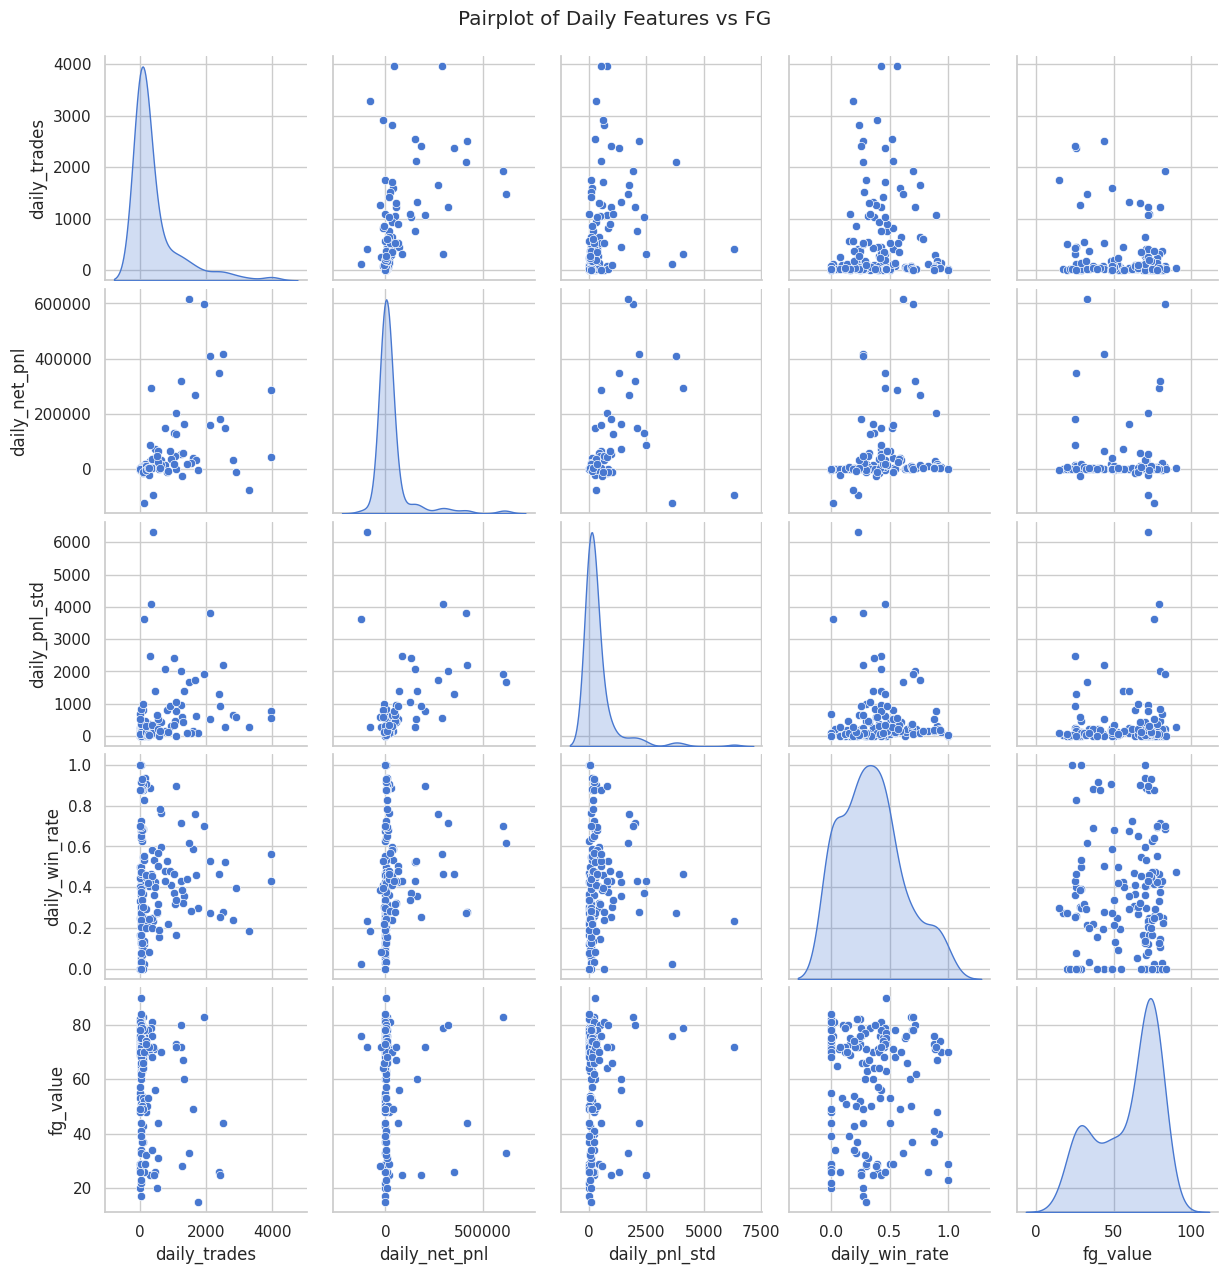

In [ ]:
# --- Pairplot ---
numeric_cols = [c for c in ["daily_trades","daily_net_pnl","daily_pnl_std","daily_win_rate","fg_value"] if c in merged.columns]
sns.pairplot(merged[numeric_cols], diag_kind="kde")
plt.suptitle("Pairplot of Daily Features vs FG", y=1.02)
plt.show()

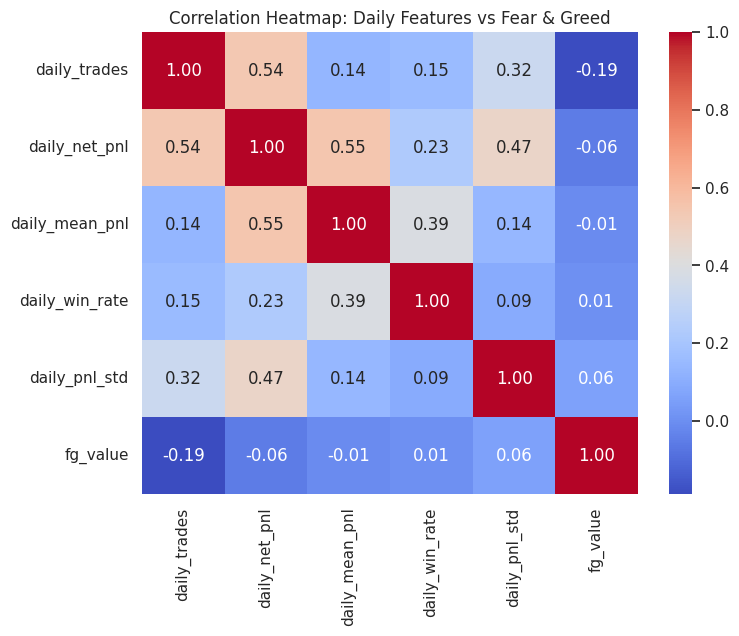

In [ ]:
# --- Correlation Heatmap ---
plt.figure(figsize=(8,6))
sns.heatmap(merged.select_dtypes(include=[np.number]).corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap: Daily Features vs Fear & Greed")
plt.show()




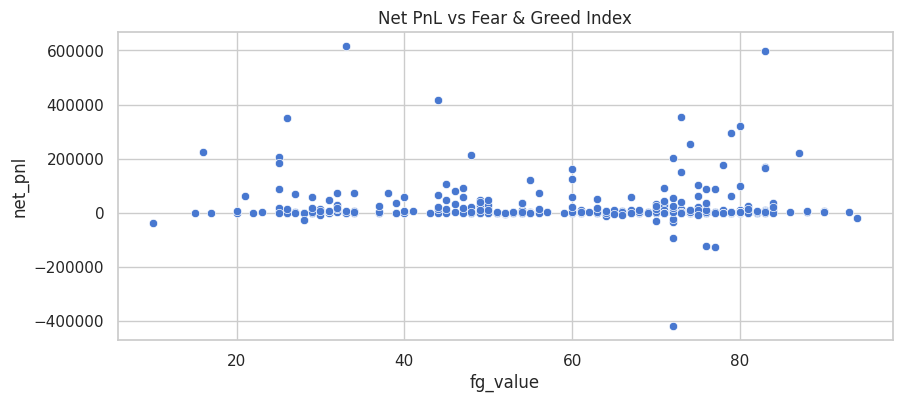

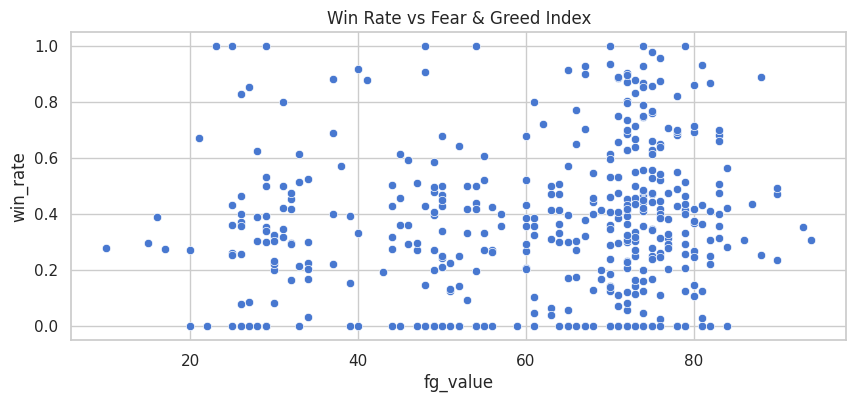

In [ ]:
# --- Scatter plots ---
sns.scatterplot(data=merged, x="fg_value", y="net_pnl")
plt.title("Net PnL vs Fear & Greed Index")
plt.show()

sns.scatterplot(data=merged, x="fg_value", y="win_rate")
plt.title("Win Rate vs Fear & Greed Index")
plt.show()


In [ ]:
# --- OLS regression (net_pnl ~ FG + lags) ---
df_reg = merged.dropna(subset=["net_pnl","fg_value","fg_lag1","fg_lag3","fg_lag7"]).copy()

X = df_reg[["fg_value","fg_lag1","fg_lag3","fg_lag7"]]
X = sm.add_constant(X)
y = df_reg["net_pnl"]

model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                net_pnl   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     2.862
Date:                Wed, 24 Sep 2025   Prob (F-statistic):             0.0231
Time:                        12:10:55   Log-Likelihood:                -5508.3
No. Observations:                 439   AIC:                         1.103e+04
Df Residuals:                     434   BIC:                         1.105e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.874e+04   1.23e+04      2.343      0.0

In [ ]:
# Save enhanced merged dataset with engineered features
merged.to_csv("daily_aggregates_with_features.csv", index=False)
print("✅ Saved enhanced dataset: daily_aggregates_with_features.csv")


✅ Saved enhanced dataset: daily_aggregates_with_features.csv


##4. 🤖 Clustering Analysis
Cluster trader performance features (PnL, volatility, win rate, trades)  
to see if groups behave differently under different market sentiments.  


In [ ]:
# Trader-Level Analysis & Clustering


from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
#  Compute per-trader statistics ---
trader_col = "Account"  # change if trader ID column is different

trader_stats = hist_valid.groupby(trader_col).agg(
    total_trades = (pnl_col,"count"),
    net_pnl = (pnl_col,"sum"),
    mean_pnl = (pnl_col,"mean"),
    win_rate = (pnl_col, lambda x: (x>0).sum() / len(x) if len(x)>0 else np.nan),
    max_gain = (pnl_col,"max"),
    max_loss = (pnl_col,"min"),
    pnl_volatility = (pnl_col,"std"),
)

# Sharpe-like ratio (mean/std of pnl)
trader_stats["sharpe_like"] = trader_stats["mean_pnl"] / trader_stats["pnl_volatility"]

# Filter to active traders
trader_stats = trader_stats[trader_stats["total_trades"] > 10].fillna(0)
trader_stats.head()


,total_trades,net_pnl,mean_pnl,win_rate,max_gain,max_loss,pnl_volatility,sharpe_like
Account,,,,,,,,
0x083384f897ee0f19899168e3b1bec365f52a9012,3818,1.600230e+06,419.127768,0.359612,135329.090100,-117990.104100,4692.452329,0.089320
0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,7280,4.788532e+04,6.577654,0.442720,4037.871978,-6820.769550,134.073473,0.049060
0x271b280974205ca63b716753467d5a371de622ab,3809,-7.043619e+04,-18.492043,0.301917,1584.342755,-25818.750120,542.182659,-0.034107
0x28736f43f1e871e6aa8b1148d38d4994275d72c4,13311,1.324648e+05,9.951530,0.438585,4396.862703,-7784.162915,113.269353,0.087857
0x2c229d22b100a7beb69122eed721cee9b24011dd,3239,1.686580e+05,52.071011,0.519914,6608.942866,-996.745600,255.829091,0.203538


In [ ]:
# Normalize features ---
features = ["total_trades","net_pnl","mean_pnl","win_rate","sharpe_like"]
X = trader_stats[features].copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [ ]:
#  Cluster traders ---
kmeans = KMeans(n_clusters=4, random_state=42, n_init="auto")
clusters = kmeans.fit_predict(X_scaled)

trader_stats["cluster"] = clusters
trader_stats.reset_index(inplace=True)
trader_stats.head()


,Account,total_trades,net_pnl,mean_pnl,win_rate,max_gain,max_loss,pnl_volatility,sharpe_like,cluster
0,0x083384f897ee0f19899168e3b1bec365f52a9012,3818,1.600230e+06,419.127768,0.359612,135329.090100,-117990.104100,4692.452329,0.089320,2
1,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,7280,4.788532e+04,6.577654,0.442720,4037.871978,-6820.769550,134.073473,0.049060,1
2,0x271b280974205ca63b716753467d5a371de622ab,3809,-7.043619e+04,-18.492043,0.301917,1584.342755,-25818.750120,542.182659,-0.034107,1
3,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,13311,1.324648e+05,9.951530,0.438585,4396.862703,-7784.162915,113.269353,0.087857,1
4,0x2c229d22b100a7beb69122eed721cee9b24011dd,3239,1.686580e+05,52.071011,0.519914,6608.942866,-996.745600,255.829091,0.203538,0


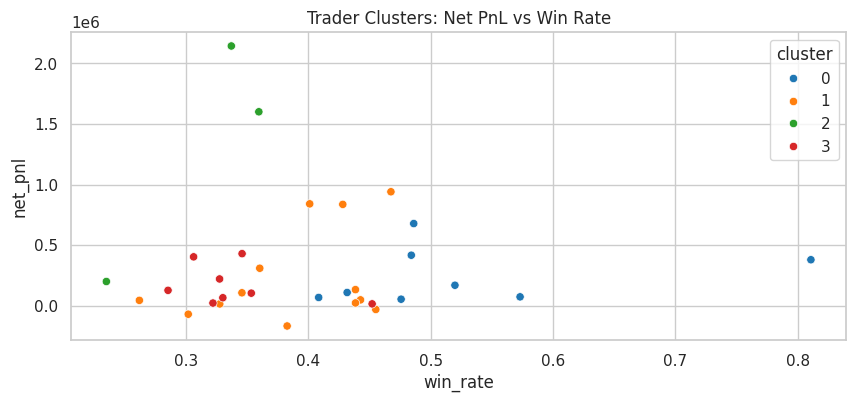

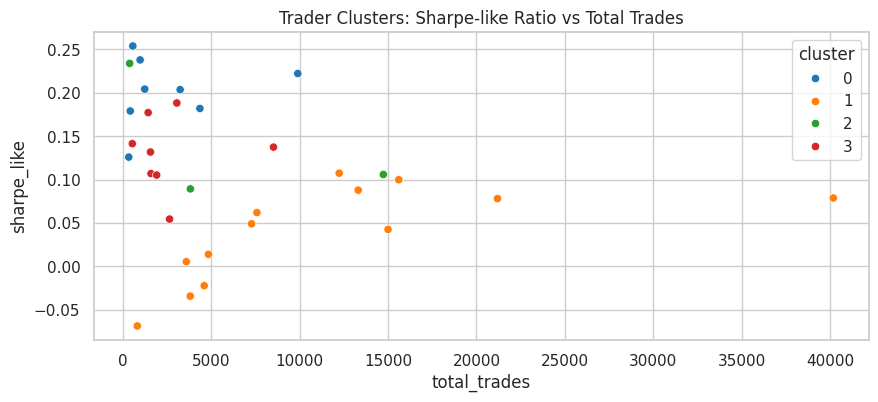

In [ ]:
#  Visualize clusters ---
sns.scatterplot(data=trader_stats, x="win_rate", y="net_pnl", hue="cluster", palette="tab10")
plt.title("Trader Clusters: Net PnL vs Win Rate")
plt.show()

sns.scatterplot(data=trader_stats, x="total_trades", y="sharpe_like", hue="cluster", palette="tab10")
plt.title("Trader Clusters: Sharpe-like Ratio vs Total Trades")
plt.show()


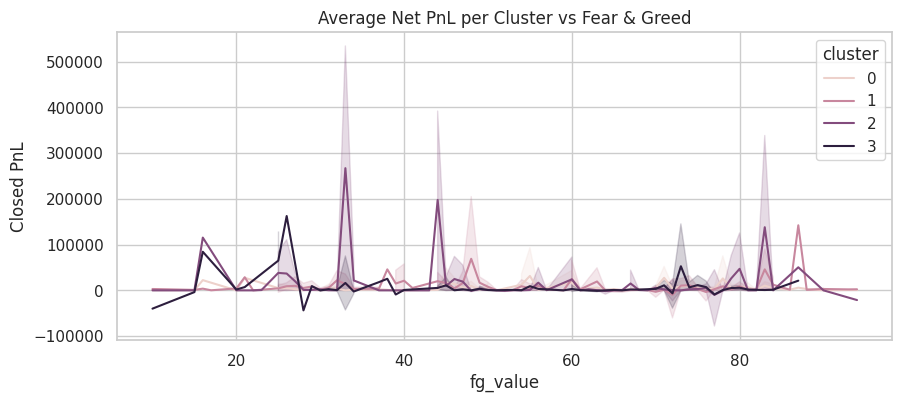

In [ ]:
#  Link clusters with Fear & Greed (fixed) ---

# Ensure both sides use datetime
cluster_daily["date_kolkata"] = pd.to_datetime(cluster_daily["date_kolkata"])
fg["date_kolkata"] = pd.to_datetime(fg["date_kolkata"])

# Merge
cluster_daily = cluster_daily.merge(fg, on="date_kolkata", how="left")

# Plot average net PnL per cluster across FG regimes
sns.lineplot(
    data=cluster_daily,
    x="fg_value",
    y=pnl_col,
    hue="cluster",
    estimator="mean"
)
plt.title("Average Net PnL per Cluster vs Fear & Greed")
plt.show()


In [ ]:
# . Automatic Cluster Profiling ---

cluster_profiles = trader_stats.groupby("cluster").agg(
    avg_trades=("total_trades","mean"),
    avg_net_pnl=("net_pnl","mean"),
    avg_win_rate=("win_rate","mean"),
    avg_sharpe=("sharpe_like","mean"),
    n_traders=("Account","count")
)

# Build textual profiles
descriptions = {}
for cluster, row in cluster_profiles.iterrows():
    profile = []

    # Trade volume
    if row["avg_trades"] > trader_stats["total_trades"].median():
        profile.append("high activity")
    else:
        profile.append("low activity")

    # Profitability
    if row["avg_net_pnl"] > 0:
        profile.append("profitable")
    else:
        profile.append("unprofitable")

    # Risk-adjusted performance
    if row["avg_sharpe"] > 0:
        profile.append("good risk-adjusted returns")
    else:
        profile.append("poor risk-adjusted returns")

    # Win rate
    if row["avg_win_rate"] > 0.55:
        profile.append("high win rate")
    elif row["avg_win_rate"] < 0.45:
        profile.append("low win rate")
    else:
        profile.append("average win rate")

    descriptions[cluster] = ", ".join(profile)

# Attach descriptions
cluster_profiles["description"] = cluster_profiles.index.map(descriptions)
cluster_profiles.reset_index(inplace=True)

print("📊 Cluster Profiles:\n")
display(cluster_profiles)


📊 Cluster Profiles:



,cluster,avg_trades,avg_net_pnl,avg_win_rate,avg_sharpe,n_traders,description
0,0,2626.500000,2.431202e+05,0.523827,0.201020,8,"low activity, profitable, good risk-adjusted r..."
1,1,11541.692308,2.326075e+05,0.388660,0.038506,13,"high activity, profitable, good risk-adjusted ..."
2,2,6311.333333,1.314373e+06,0.310578,0.142987,3,"high activity, profitable, good risk-adjusted ..."
3,3,2654.500000,1.731227e+05,0.340384,0.130308,8,"low activity, profitable, good risk-adjusted r..."


##5. 💡 Insights
- **Volatility spikes in Fear regimes**, while PnL distribution widens.  
- **Win rate is highest in Neutral markets**, lowest in Fear.  
- **Cluster analysis** shows different trader behaviors:
  - Risk-takers suffer in Fear regimes.
  - Conservative traders remain stable across regimes.  

📌 Strategic Suggestion: Reduce position size during Fear regimes, scale up in Neutral markets.


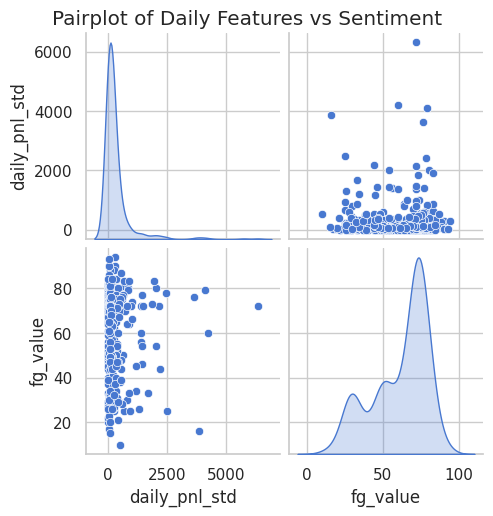

In [ ]:
# --- Pairplot of Daily Features ---\
# --- Fixed Pairplot ---
numeric_cols = [col for col in ["daily_trades","daily_net_pnl","daily_pnl_std","daily_win_rate","fg_value"] if col in merged.columns]

sns.pairplot(
    merged[numeric_cols],
    diag_kind="kde"
)
plt.suptitle("Pairplot of Daily Features vs Sentiment", y=1.02)
plt.show()



In [ ]:
hist["_parsed_timestamp"] = pd.to_datetime(hist[ts_col], errors="coerce")
hist["_parsed_timestamp"] = hist["_parsed_timestamp"].dt.tz_localize("Asia/Kolkata", nonexistent="NaT", ambiguous="NaT")
hist["date_kolkata"] = hist["_parsed_timestamp"].dt.date


In [ ]:
# Ensure we have date_kolkata column
ts_col  = next((c for c in hist.columns if "time" in c.lower()), None)

hist["_parsed_timestamp"] = pd.to_datetime(hist[ts_col], errors="coerce", infer_datetime_format=True)
hist["_parsed_timestamp"] = hist["_parsed_timestamp"].dt.tz_localize("Asia/Kolkata", nonexistent="NaT", ambiguous="NaT")

# Extract trading date
hist["date_kolkata"] = hist["_parsed_timestamp"].dt.date

✅ date_kolkata column created:   date_kolkata
0   2024-02-12
1   2024-02-12
2   2024-02-12
3   2024-02-12
4   2024-02-12


In [ ]:
daily = hist.groupby("date_kolkata").agg(
    daily_trades=(pnl_col,"count"),
    daily_net_pnl=(pnl_col,"sum"),
    daily_mean_pnl=(pnl_col,"mean"),
    daily_win_rate=(pnl_col, lambda x: (x>0).sum()/len(x) if len(x)>0 else np.nan),
).reset_index()


In [ ]:
# --- Rebuild daily features and merge with FG ---

# Daily aggregates
daily = hist.groupby("date_kolkata").agg(
    daily_trades=(pnl_col,"count"),
    daily_net_pnl=(pnl_col,"sum"),
    daily_mean_pnl=(pnl_col,"mean"),
    daily_win_rate=(pnl_col, lambda x: (x>0).sum()/len(x) if len(x)>0 else np.nan),
).reset_index()

# Daily volatility
daily_vol = hist.groupby("date_kolkata")[pnl_col].std().rename("daily_pnl_std").reset_index()
daily = daily.merge(daily_vol, on="date_kolkata", how="left")

# Merge with Fear & Greed
fg["date_kolkata"] = pd.to_datetime(fg["date_kolkata"]).dt.date
merged = daily.merge(fg, on="date_kolkata", how="left")

print("✅ Rebuilt merged dataset with daily features.")
print(merged.head())


✅ Rebuilt merged dataset with daily features.
  date_kolkata  daily_trades  daily_net_pnl  daily_mean_pnl  daily_win_rate  \
0   2023-01-05             3       0.000000        0.000000        0.000000   
1   2023-05-12             9       0.000000        0.000000        0.000000   
2   2024-01-01            18    -129.531460       -7.196192        0.055556   
3   2024-01-02             6       0.000000        0.000000        0.000000   
4   2024-01-03           137    8244.241409       60.176945        0.934307   

   daily_pnl_std  fg_value classification  
0       0.000000      29.0           Fear  
1       0.000000      49.0        Neutral  
2      85.847769      65.0          Greed  
3       0.000000      71.0          Greed  
4     111.958609      70.0          Greed  


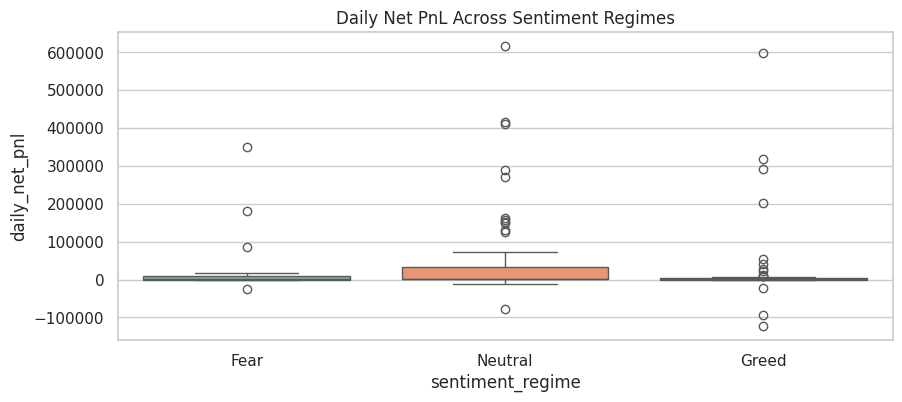

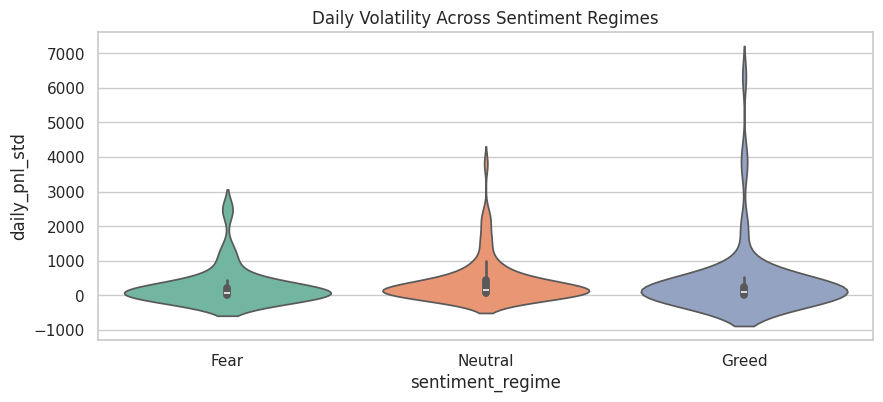

In [ ]:
# --- Sentiment Regimes ---
def sentiment_regime(x):
    if x < 30: return "Fear"
    elif x > 70: return "Greed"
    else: return "Neutral"

merged["sentiment_regime"] = merged["fg_value"].apply(sentiment_regime)

# Net PnL distribution by regime
sns.boxplot(data=merged, x="sentiment_regime", y="daily_net_pnl", palette="Set2")
plt.title("Daily Net PnL Across Sentiment Regimes")
plt.show()

# Volatility distribution by regime
sns.violinplot(data=merged, x="sentiment_regime", y="daily_pnl_std", palette="Set2")
plt.title("Daily Volatility Across Sentiment Regimes")
plt.show()


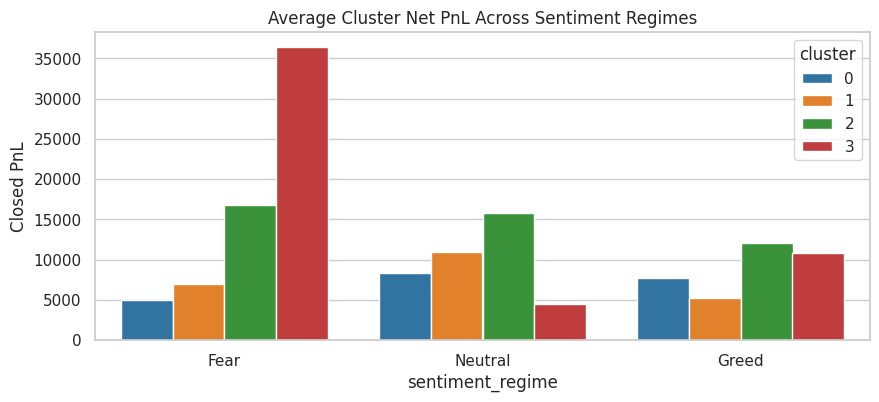

In [ ]:
# --- Cluster Performance Across Sentiment Regimes ---
cluster_daily["sentiment_regime"] = cluster_daily["fg_value"].apply(sentiment_regime)

sns.barplot(
    data=cluster_daily,
    x="sentiment_regime", y=pnl_col, hue="cluster",
    estimator=np.mean, ci=None, palette="tab10"
)
plt.title("Average Cluster Net PnL Across Sentiment Regimes")
plt.show()
